# Churn Model

Predicting churn with logistic regression using features from the previous feature engineering notebook.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load features
features_df = pd.read_csv('../data/features_for_modeling.csv')
print(f"Loaded {len(features_df):,} users")
print(f"Churn rate: {features_df['is_churn'].mean()*100:.1f}%")

Loaded 933,578 users
Churn rate: 6.2%


933,578 users with 6.2% churn rate, matching the feature engineering output.

In [3]:
# Prepare features for modeling
# Drop ID column and separate target
X = features_df.drop(columns=['msno', 'is_churn'])
y = features_df['is_churn']

# Handle missing values (same as feature engineering)
X['city'] = X['city'].fillna(-1)
X['registered_via'] = X['registered_via'].fillna(-1)
X['gender'] = X['gender'].fillna('unknown')
X['age'] = X['age'].fillna(X['age'].median())
X['tenure_days'] = X['tenure_days'].fillna(X['tenure_days'].median())

# One-hot encode gender
X = pd.get_dummies(X, columns=['gender'], drop_first=True)

print(f"Features: {X.shape[1]}")
print(X.dtypes)

Features: 23
payment_method_id              int64
payment_plan_days              int64
plan_list_price                int64
actual_amount_paid             int64
discount                       int64
is_auto_renew                  int64
is_cancel                      int64
city                           int64
age                            int64
registered_via                 int64
tenure_days                    int64
observable_months              int64
days_active_last30             int64
songs_skipped_last30           int64
songs_completed_last30         int64
unique_songs_last30            int64
hours_listened_last30        float64
transactions_per_month       float64
days_active_per_month        float64
songs_completed_per_month    float64
hours_listened_per_month     float64
gender_male                     bool
gender_unknown                  bool
dtype: object


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train):,} ({y_train.mean()*100:.1f}% churn)")
print(f"Test: {len(X_test):,} ({y_test.mean()*100:.1f}% churn)")

Train: 746,862 (6.2% churn)
Test: 186,716 (6.2% churn)


In [5]:
# Scale features and add constant for statsmodels
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add constant for intercept
X_train_sm = sm.add_constant(X_train_scaled)
X_test_sm = sm.add_constant(X_test_scaled)

In [6]:
# Train logistic regression with statsmodels
model = sm.Logit(y_train, X_train_sm).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.114402
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               is_churn   No. Observations:               746862
Model:                          Logit   Df Residuals:                   746838
Method:                           MLE   Df Model:                           23
Date:                Tue, 27 Jan 2026   Pseudo R-squ.:                  0.5079
Time:                        00:13:25   Log-Likelihood:                -85443.
converged:                       True   LL-Null:                   -1.7363e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5950      0.009   -382.689      0.000      -3.613      -3.577
x1             0.0589      0.

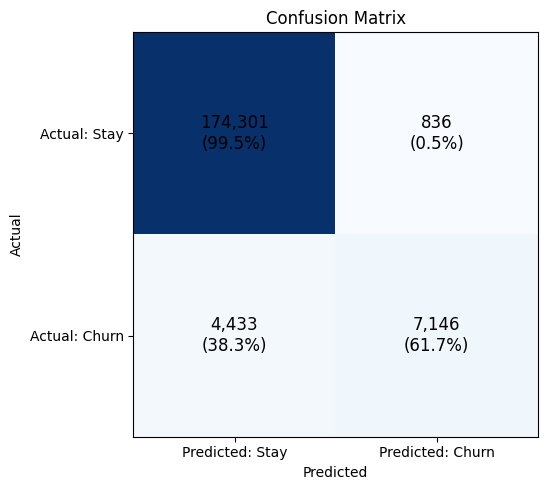


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    175137
           1       0.90      0.62      0.73     11579

    accuracy                           0.97    186716
   macro avg       0.94      0.81      0.86    186716
weighted avg       0.97      0.97      0.97    186716



In [7]:
# Predictions
y_pred_proba = model.predict(X_test_sm)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap='Blues')

# Labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Predicted: Stay', 'Predicted: Churn'])
ax.set_yticklabels(['Actual: Stay', 'Actual: Churn'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Add counts and percentages
for i in range(2):
    for j in range(2):
        total = cm[i].sum()
        pct = cm[i, j] / total * 100
        ax.text(j, i, f'{cm[i, j]:,}\n({pct:.1f}%)', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

The model catches 61% of churners (39% missed) with 88% precision when predicting churn. The tradeoff between false positives and false negatives depends on intervention costs.

In [8]:
# AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.3f}")

AUC: 0.925


AUC of 0.925 indicates strong discriminative ability. The model effectively ranks users by churn probability, even if the default threshold misses some churners.

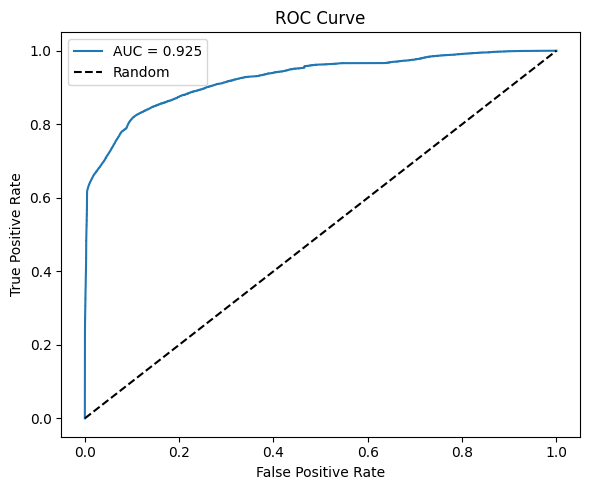

In [9]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

The ROC curve shows the model performs well above random chance across all thresholds.

In [10]:
# Odds ratios with 95% confidence intervals
feature_names = ['intercept'] + list(X.columns)
odds_ratios_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': model.params.values,
    'odds_ratio': np.exp(model.params.values),
    'ci_lower': np.exp(model.conf_int().iloc[:, 0].values),
    'ci_upper': np.exp(model.conf_int().iloc[:, 1].values)
})

# Sort by odds ratio distance from 1 (effect size)
odds_ratios_df['effect_size'] = np.abs(np.log(odds_ratios_df['odds_ratio']))
odds_ratios_df = odds_ratios_df.sort_values('effect_size', ascending=False)

print("Odds ratios with 95% CI (sorted by effect size):")
print(odds_ratios_df[['feature', 'odds_ratio', 'ci_lower', 'ci_upper']].head(11).to_string(index=False))

Odds ratios with 95% CI (sorted by effect size):
                  feature  odds_ratio  ci_lower  ci_upper
                intercept    0.027461  0.026960  0.027971
        payment_plan_days    4.372912  4.082541  4.683935
                is_cancel    2.355045  2.339227  2.370971
            is_auto_renew    0.530844  0.525096  0.536655
        observable_months    1.586690  1.550878  1.623330
   transactions_per_month    1.481188  1.463080  1.499521
          plan_list_price    1.385244       NaN       NaN
       actual_amount_paid    1.362614       NaN       NaN
 hours_listened_per_month    0.815713  0.713601  0.932437
songs_completed_per_month    1.206620  1.062784  1.369921
                 discount    1.175253       NaN       NaN


Top predictors of churn by odds ratio (OR). OR > 1 means higher churn odds; OR < 1 means lower. For example, OR = 2.36 means 2.4x higher odds of churning.

**Increases churn odds:**
- payment_plan_days: OR = 4.37 (95% CI: 4.08-4.68). Longer plans typically lack auto-renew.
- is_cancel: OR = 2.36 (2.34-2.37). Previous cancellation more than doubles churn odds.
- observable_months: OR = 1.59 (1.55-1.62). Users with longer observable history churn more.
- transactions_per_month: OR = 1.48 (1.46-1.50). More frequent transactions associated with higher churn.

**Decreases churn odds:**
- is_auto_renew: OR = 0.53 (0.53-0.54). Auto-renew reduces churn odds by 47%.
- hours_listened_per_month: OR = 0.82 (0.71-0.93). More listening reduces churn.

Note: plan_list_price, actual_amount_paid, and discount show multicollinearity (discount = list_price - amount_paid), producing unstable estimates.

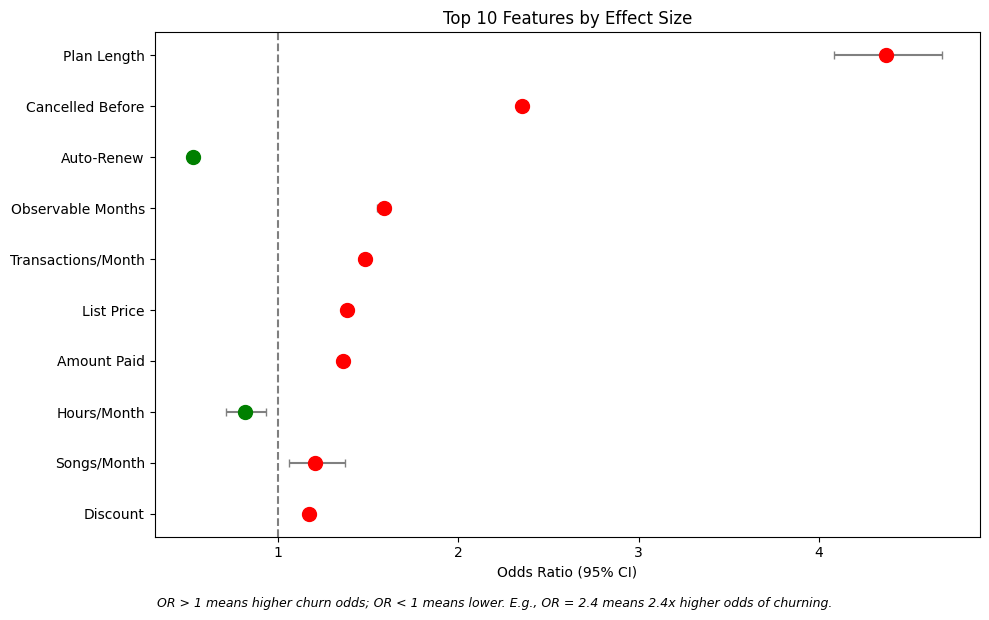

In [12]:
# Visualize odds ratios with confidence intervals
label_map = {
    'payment_plan_days': 'Plan Length',
    'is_cancel': 'Cancelled Before',
    'is_auto_renew': 'Auto-Renew',
    'plan_list_price': 'List Price',
    'actual_amount_paid': 'Amount Paid',
    'transactions_per_month': 'Transactions/Month',
    'days_active_last30': 'Recent Activity',
    'days_active_per_month': 'Days Active/Month',
    'discount': 'Discount',
    'tenure_days': 'Tenure',
    'songs_completed_per_month': 'Songs/Month',
    'hours_listened_per_month': 'Hours/Month',
    'observable_months': 'Observable Months'
}

# Get top 10 features (excluding intercept)
top_features = odds_ratios_df[odds_ratios_df['feature'] != 'intercept'].head(10).copy()
top_features['label'] = top_features['feature'].map(label_map).fillna(top_features['feature'])

plt.figure(figsize=(10, 6))
y_pos = range(len(top_features))
colors = ['green' if or_ < 1 else 'red' for or_ in top_features['odds_ratio']]

# Plot odds ratios with error bars for CI
plt.errorbar(
    top_features['odds_ratio'], 
    y_pos,
    xerr=[top_features['odds_ratio'] - top_features['ci_lower'], 
          top_features['ci_upper'] - top_features['odds_ratio']],
    fmt='o', 
    color='black',
    ecolor='gray',
    capsize=3
)

# Color the points
for i, (or_, color) in enumerate(zip(top_features['odds_ratio'], colors)):
    plt.scatter(or_, i, color=color, s=100, zorder=5)

plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)
plt.yticks(y_pos, top_features['label'])
plt.xlabel('Odds Ratio (95% CI)')
plt.title('Top 10 Features by Effect Size')
plt.figtext(0.5, -0.02, 'OR > 1 means higher churn odds; OR < 1 means lower. E.g., OR = 2.4 means 2.4x higher odds of churning.', 
            ha='center', fontsize=9, style='italic')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Summary

**Model Fit:**
- Pseudo R-squared: 0.51 - the features explain about half of what determines whether a user churns. For behavioral prediction this is high; 0.2-0.4 is typically considered good.
- AUC: 0.925, strong discriminative ability for ranking users by churn risk
- Precision: 88%, Recall: 61% at default threshold

**Key Predictors (odds ratios):**
- payment_plan_days (OR = 4.37): Strongest predictor. Longer plans lack auto-renew.
- is_cancel (OR = 2.36): Previous cancellation doubles churn odds.
- is_auto_renew (OR = 0.53): Auto-renew reduces churn odds by 47%.
- Listening features have weaker effects than subscription mechanics.

**Business Implications:**
- Promote auto-renew adoption. Users without it churn at 8x the rate.
- Target long-term prepaid users with renewal reminders before expiration.
- Flag users with previous cancellations for proactive retention outreach.